In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, log_loss

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_theme(style="whitegrid")

In [59]:
df_teaching = pd.read_excel('Teaching staff.xlsx', sheet_name='Data',header=3, na_values=['...', '…'])
df_women_legislators = pd.read_excel('Women legislators and managers.xlsx', sheet_name='Data', header=3, na_values=['...', '…'])
df_legal_age = pd.read_excel('Legal Age for Marriage.xlsx', sheet_name='Data', header=3, na_values=['...', '…'])
df_marriages = pd.read_excel('Marriages.xlsx', sheet_name='Data', header=5, na_values=['...', '…'])
df_part_time = pd.read_excel('Part-time employment.xlsx', sheet_name='Data', header=5, na_values=['...', '…'])

In [60]:
df_teaching.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country or area  205 non-null    object 
 1   Year             195 non-null    float64
 2   Unnamed: 2       20 non-null     object 
 3   %                195 non-null    float64
 4   Unnamed: 4       0 non-null      float64
 5   Year.1           181 non-null    float64
 6   Unnamed: 6       37 non-null     object 
 7   %.1              181 non-null    float64
 8   Unnamed: 8       0 non-null      float64
 9   Year.2           163 non-null    float64
 10  Unnamed: 10      26 non-null     object 
 11  %.2              163 non-null    float64
dtypes: float64(8), object(4)
memory usage: 19.3+ KB


In [61]:
df_marriages = df_marriages.drop('Unnamed: 4', axis=1)
df_marriages = df_marriages.drop('Unnamed: 7', axis=1)

In [62]:
df_marriages.columns.values[0] = 'Country'
df_marriages.columns.values[2] = 'population women 15-19 ever married (%)'
df_marriages.columns.values[3] = 'population men 15-19 ever married (%)'
df_marriages.columns.values[4] = 'women average single age before marriage (year)'
df_marriages.columns.values[5] = 'men average single age before marriage (year)'
df_marriages.columns.values[6] = 'Source'
df_marriages.head()

,Country,Year,population women 15-19 ever married (%),population men 15-19 ever married (%),women average single age before marriage (year),men average single age before marriage (year),Source
0,Afghanistan,2010,17.3,NaN,21.5,NaN,DHS
1,Albania,2011,7.2,2.0,25.1,29.2,NS
2,Algeria,2002,1.8,0.2,29.5,33.0,PAPFAM
3,American Samoa,2000,21.4,NaN,25.7,NaN,USCB
4,Angola,1970,35.7,7.6,19.4,24.5,USCB


In [63]:
df_women_legislators.columns.values[0] = 'Country'
df_women_legislators.columns.values[3] = 'Women legislators (%)'
df_women_legislators.columns.values[2] = 'Type'
df_women_legislators.head()

,Country,Year,Type,Women legislators (%),Source
0,Algeria,2004,NaN,4.870624,LFS
1,Anguilla,2001,NaN,52.032520,PC
2,Antigua and Barbuda,2001,NaN,45.059786,PC
3,Argentina,2006,"a,b",23.120202,LFS
4,Armenia,2001,NaN,23.939559,PC


In [64]:
df_legal_age = df_legal_age.drop("With parental consent ",axis=1)
df_legal_age = df_legal_age.drop("Unnamed: 10",axis=1)

In [65]:
df_legal_age.columns.values[0] = 'Country'
df_legal_age.columns.values[1] = 'women w/o parental consent minimum age'
df_legal_age.columns.values[2] = 'Type'
df_legal_age.columns.values[3] = 'Men w/o parental consent minimum age'
df_legal_age.columns.values[4] = 'Type'
df_legal_age.columns.values[5] = 'women with parental consent minimum age'
df_legal_age.columns.values[6] = 'Type'
df_legal_age.columns.values[7] = 'Men with parental consent minimum age'
df_legal_age.columns.values[8] = 'Type'
df_legal_age.columns.values[9] = 'Year'
df_legal_age.head()
# Drop first row if Country is NaN
if pd.isna(df_legal_age.iloc[0]['Country']):
    df_legal_age = df_legal_age.drop(0).reset_index(drop=True)
df_legal_age.head()
# in the man and women parental consent minimum age columns, replace values like <18 to 18 and lower it by one
# if its like 9-15, just take the lower value
def clean_age(age):
    if isinstance(age, str) and age.startswith('<'):
        return float(age[1:]) - 1
    if isinstance(age, str) and '-' in age:
        parts = age.split('-')
        try:
            return float(parts[0].strip())
        except ValueError:
            return np.nan
    return float(age)   

df_legal_age['women with parental consent minimum age'] = df_legal_age['women with parental consent minimum age'].apply(clean_age)
df_legal_age['Men with parental consent minimum age'] = df_legal_age['Men with parental consent minimum age'].apply(clean_age)
# there are values in the women w/o parental consent minimum age and men w/o parental consent minimum age columns like '12.5 and 19' or '12.5-18'
# if it doesnt need cleaning, just leave it at that
def clean_age_range(age):
    if isinstance(age, str):
        if 'and' in age:
            parts = age.split('and')
            try:
                return float(parts[0].strip())
            except ValueError:
                return np.nan
        elif '-' in age:
            parts = age.split('-')
            try:
                return float(parts[0].strip())
            except ValueError:
                return np.nan
    return age
df_legal_age['women w/o parental consent minimum age'] = df_legal_age['women w/o parental consent minimum age'].apply(clean_age_range)
df_legal_age['Men w/o parental consent minimum age'] = df_legal_age['Men w/o parental consent minimum age'].apply(clean_age_range)
# There are country names like "Slovakia13", remove the numbers from the names
df_legal_age['Country'] = df_legal_age['Country'].str.replace(r'\d+', '', regex=True).str.strip()
df_legal_age

,Country,women w/o parental consent minimum age,Type,Men w/o parental consent minimum age,Type,women with parental consent minimum age,Type,Men with parental consent minimum age,Type,Year,Source
0,Afghanistan,16.0,NaN,18.0,NaN,15.0,NaN,NaN,NaN,2011,UNPD
1,Aland Islands,18.0,NaN,18.0,NaN,NaN,NaN,NaN,NaN,2011,UNSD
2,Albania,NaN,NaN,NaN,NaN,16.0,NaN,18.0,NaN,2011,UNSD
3,Algeria,19.0,NaN,19.0,NaN,NaN,NaN,NaN,NaN,2012,CEDAW (51st session)
4,Andorra,16.0,NaN,16.0,NaN,14.0,NaN,14.0,NaN,2001,CEDAW (25th session)
...,...,...,...,...,...,...,...,...,...,...,...
205,Venezuela,12.0,NaN,12.0,NaN,NaN,NaN,NaN,NaN,2011,UNSD
206,Vietnam,18.0,NaN,20.0,NaN,NaN,NaN,NaN,NaN,2007,CEDAW (37th session)
207,Yemen,15.0,u,15.0,u,NaN,NaN,NaN,NaN,2002,CEDAW (exceptional session 2002)
208,Zambia,21.0,NaN,21.0,NaN,NaN,NaN,NaN,NaN,2011,CEDAW (49th session)


In [66]:
df_part_time = df_part_time.drop('Unnamed: 2', axis=1)
df_part_time.columns.values[0] = 'Country'
df_part_time.columns.values[2] = 'Type'
df_part_time.columns.values[3] = 'Female part-time (%)'
df_part_time.columns.values[4] = 'Male part-time (%)'
df_part_time.columns.values[5] = 'Female part-time/Total part-time'

In [67]:
df_part_time.head()

,Country,Year,Type,Female part-time (%),Male part-time (%),Female part-time/Total part-time,Source
0,Albania,2001,"a,b,c,d",50.200001,46.099998,39.700001,O
1,Argentina,2011,"e,f,g,h",31.299999,11.900000,64.800003,LFS
2,Armenia,2008,"b,i,j",30.100000,19.000000,56.200001,LFS
3,Aruba,1994,"e,k,j",12.300000,4.000000,71.000000,HS
4,Australia,2011,"l,b,f,m,n",38.500000,13.200000,70.900002,LFS


In [68]:
df_teaching.columns.values[0] = 'Country'
df_teaching.columns.values[3] = 'Female Teachers Primary (%)'
df_teaching.columns.values[7] = 'Female Teachers Secondary (%)'
df_teaching.columns.values[11] = 'Female Teachers Tertiary (%)'

In [69]:
df_teaching = df_teaching.drop('Unnamed: 2', axis=1)
df_teaching = df_teaching.drop('Unnamed: 4', axis=1)
df_teaching = df_teaching.drop('Unnamed: 6', axis=1)
df_teaching = df_teaching.drop('Unnamed: 8', axis=1)
df_teaching = df_teaching.drop('Unnamed: 10', axis=1)

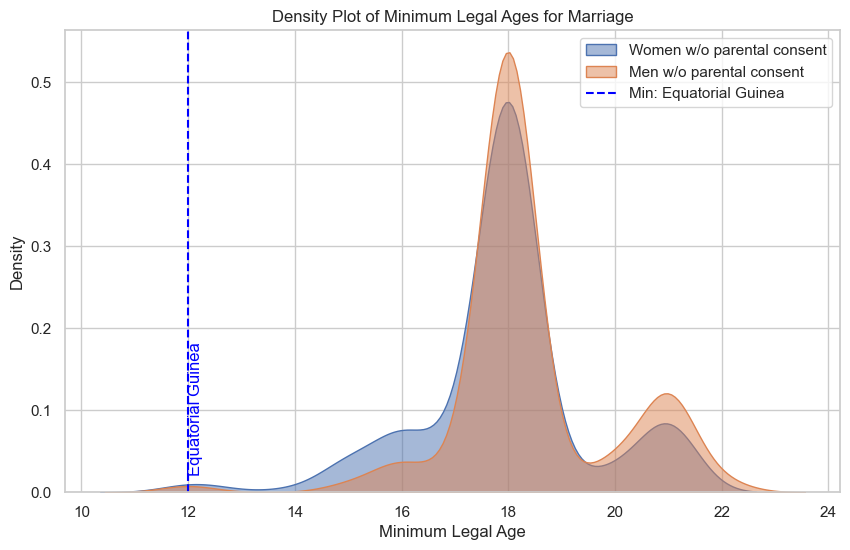

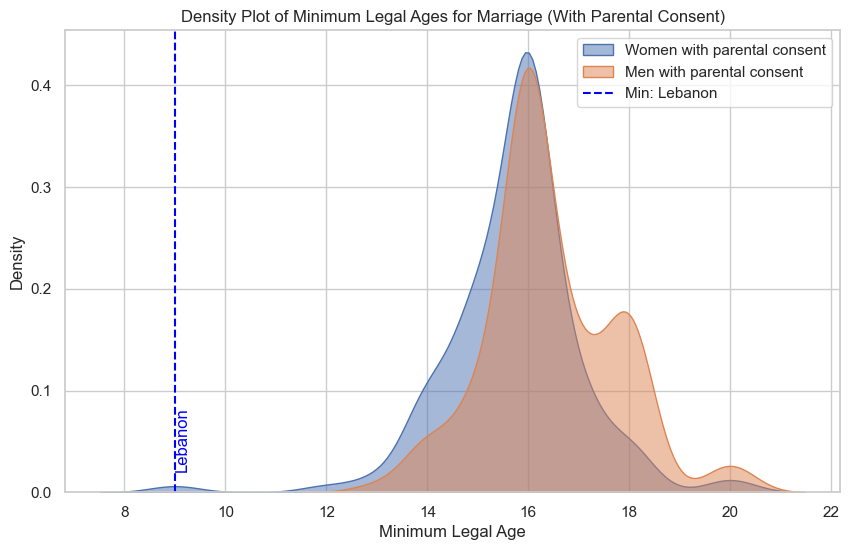

In [70]:
plt.figure(figsize=(10, 6))
# KDE plot for minimum legal ages without parental consent
sns.kdeplot(df_legal_age['women w/o parental consent minimum age'].dropna(), label='Women w/o parental consent', fill=True, alpha=0.5)
sns.kdeplot(df_legal_age['Men w/o parental consent minimum age'].dropna(), label='Men w/o parental consent', fill=True, alpha=0.5)

# Add vertical line for min value
min_country = df_legal_age.loc[df_legal_age['women w/o parental consent minimum age'].idxmin(), 'Country']
min_value = df_legal_age['women w/o parental consent minimum age'].min()

plt.axvline(min_value, color='blue', linestyle='--', label=f'Min: {min_country}')
plt.text(min_value, 0.02, f'{min_country}', rotation=90, verticalalignment='bottom', color='blue')

plt.title('Density Plot of Minimum Legal Ages for Marriage')
plt.xlabel('Minimum Legal Age')
plt.ylabel('Density')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
# KDE plot for minimum legal ages with parental consent
sns.kdeplot(df_legal_age['women with parental consent minimum age'].dropna(), label='Women with parental consent', fill=True, alpha=0.5)
sns.kdeplot(df_legal_age['Men with parental consent minimum age'].dropna(), label='Men with parental consent', fill=True, alpha=0.5)

# Add vertical line for min value
min_country_with = df_legal_age.loc[df_legal_age['women with parental consent minimum age'].idxmin(), 'Country']
min_value_with = df_legal_age['women with parental consent minimum age'].min()

plt.axvline(min_value_with, color='blue', linestyle='--', label=f'Min: {min_country_with}')
plt.text(min_value_with, 0.02, f'{min_country_with}', rotation=90, verticalalignment='bottom', color='blue')

plt.title('Density Plot of Minimum Legal Ages for Marriage (With Parental Consent)')
plt.xlabel('Minimum Legal Age')
plt.ylabel('Density')
plt.legend()
plt.show()

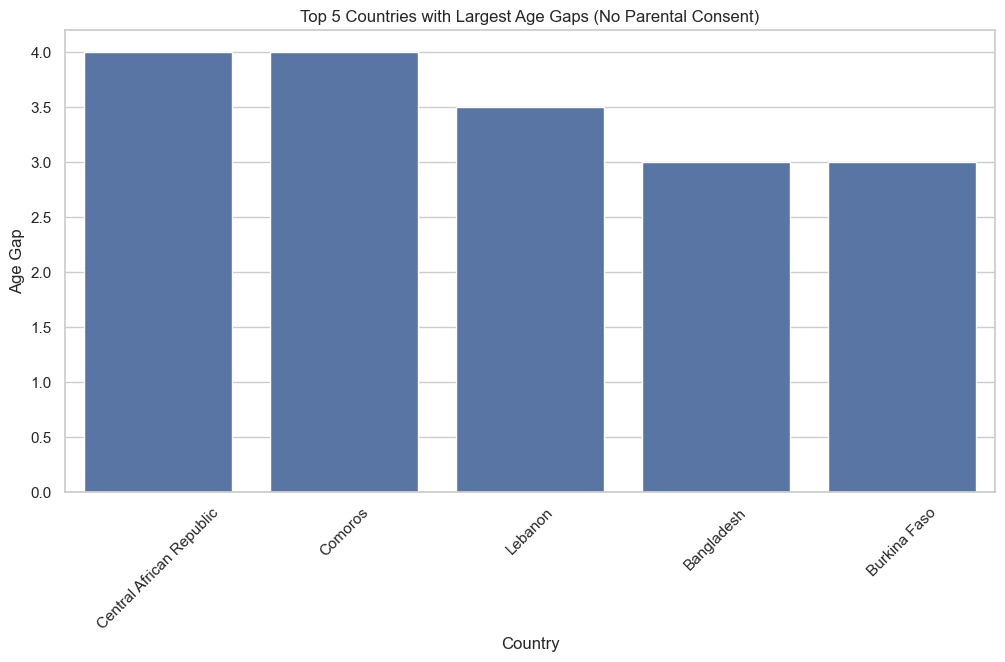

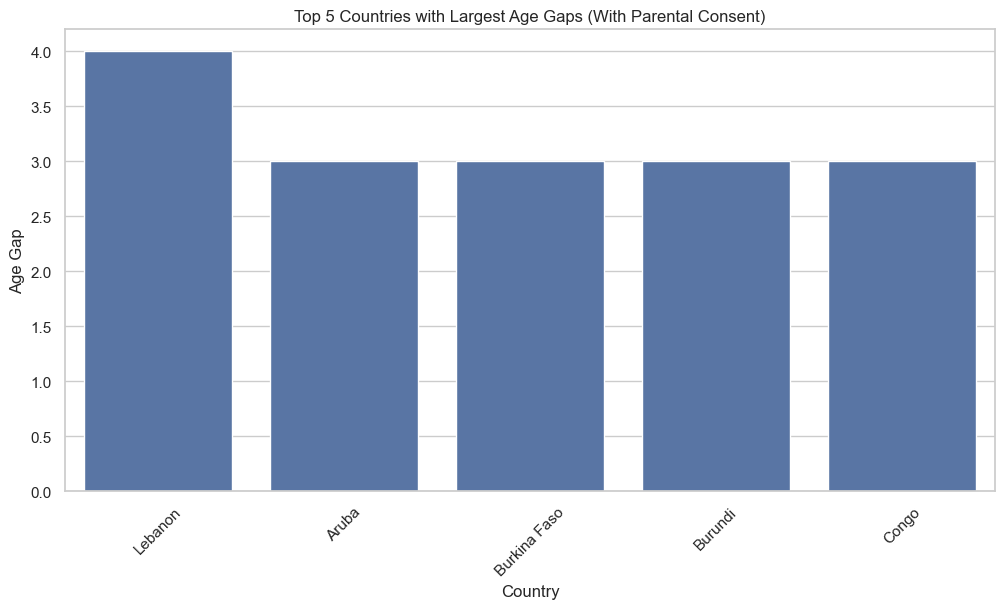

In [71]:
# Calculate age gaps without and with parental consent
df_legal_age['age_gap_no_consent'] = df_legal_age['Men w/o parental consent minimum age'] - df_legal_age['women w/o parental consent minimum age']
df_legal_age['age_gap_with_consent'] = df_legal_age['Men with parental consent minimum age'] - df_legal_age['women with parental consent minimum age']

# Get top 5 countries with largest age gaps
top_gaps_no_consent = df_legal_age.nlargest(5, 'age_gap_no_consent')
top_gaps_with_consent = df_legal_age.nlargest(5, 'age_gap_with_consent')

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=top_gaps_no_consent, x='Country', y='age_gap_no_consent')
plt.title('Top 5 Countries with Largest Age Gaps (No Parental Consent)')
plt.ylabel('Age Gap')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=top_gaps_with_consent, x='Country', y='age_gap_with_consent')
plt.title('Top 5 Countries with Largest Age Gaps (With Parental Consent)')
plt.ylabel('Age Gap')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.show()

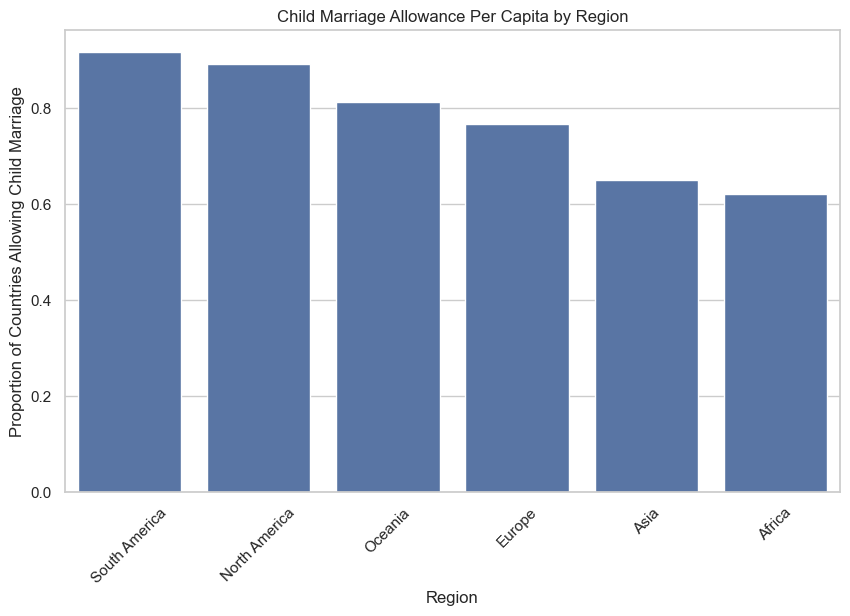

In [72]:
# Expand the dataset to include regions like Africa, Asia, Europe, Americas, Oceania
# The legal age dataset does not have region information, can we import a python package that has country to region mapping?
import pycountry_convert as pc

def country_to_continent(country_name):
    try:
        country_code = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return 'Unknown'

# Add a new column for continent/region
df_legal_age['Continent'] = df_legal_age['Country'].apply(country_to_continent)

# Check the distribution of countries by continent
df_legal_age['Continent'].value_counts()

# What is the order of child marriage allowance by region per capita?
child_marriage_by_region = df_legal_age[
    (df_legal_age['women w/o parental consent minimum age'] < 18) |
    (df_legal_age['Men w/o parental consent minimum age'] < 18) | 
    (df_legal_age['women with parental consent minimum age'] < 18) |
    (df_legal_age['Men with parental consent minimum age'] < 18)
]

# Group by continent and calculate the number of countries allowing child marriage per continent
child_marriage_counts = child_marriage_by_region.groupby('Continent').size()

# Normalize by the total number of countries per continent
total_countries_by_continent = df_legal_age.groupby('Continent').size()
child_marriage_per_capita = (child_marriage_counts / total_countries_by_continent).sort_values(ascending=False)

# Remove 'Unknown' from the results
child_marriage_per_capita = child_marriage_per_capita[child_marriage_per_capita.index != 'Unknown']

# Create a bar plot for visualization using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=child_marriage_per_capita.index, y=child_marriage_per_capita.values)
plt.title('Child Marriage Allowance Per Capita by Region')
plt.ylabel('Proportion of Countries Allowing Child Marriage')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.show()

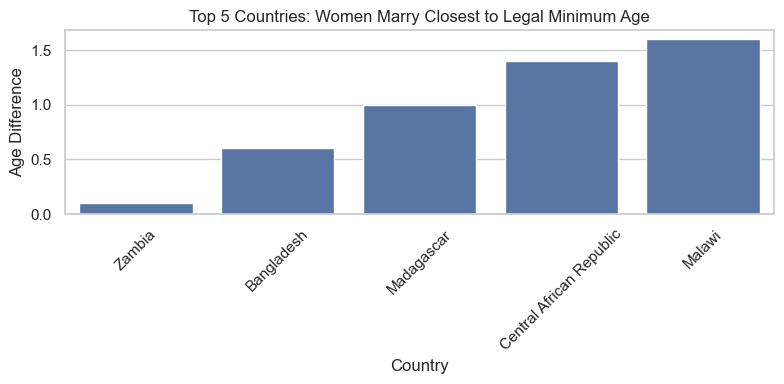

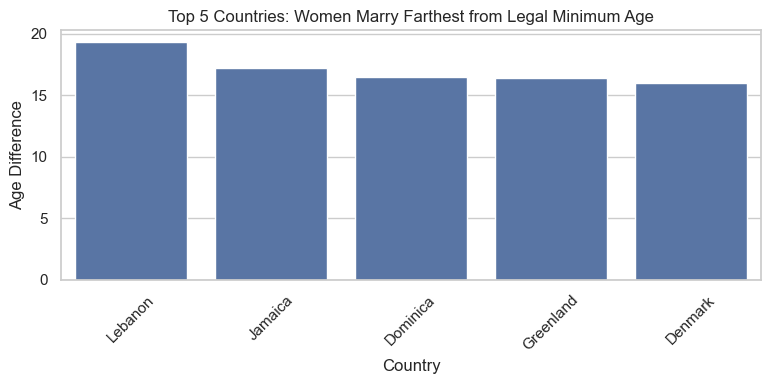

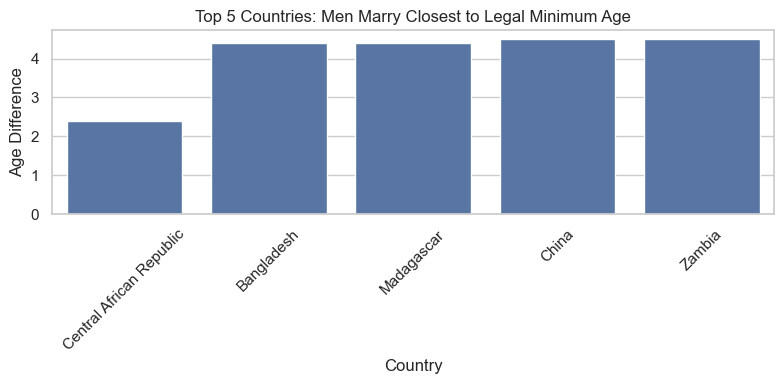

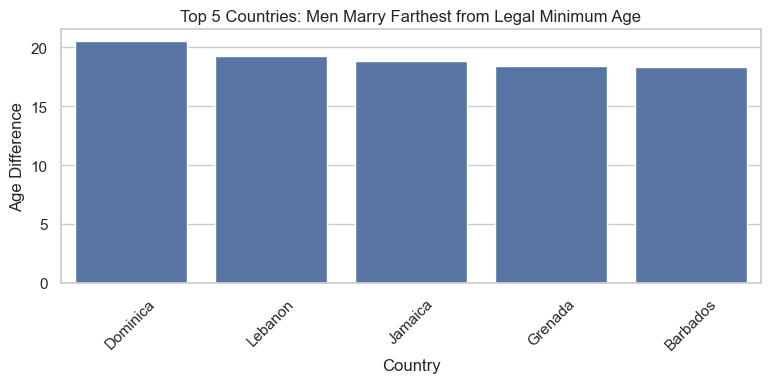

In [77]:
# Merge the legal age dataset with the marriages dataset
merged_df = pd.merge(
    df_legal_age[['Country', 'women with parental consent minimum age', 'Men with parental consent minimum age', 'women w/o parental consent minimum age', 'Men w/o parental consent minimum age']],
    df_marriages[['Country', 'women average single age before marriage (year)', 'men average single age before marriage (year)']],
    on='Country', how='inner')

# Use direct column names, fallback to 'without parental consent' if 'with parental consent' is missing
women_consent_col = 'women with parental consent minimum age'
men_consent_col = 'Men with parental consent minimum age'
women_no_consent_col = 'women w/o parental consent minimum age'
men_no_consent_col = 'Men w/o parental consent minimum age'

# Fill missing values with fallback
merged_df['women_consent_age'] = merged_df[women_consent_col].fillna(merged_df[women_no_consent_col])
merged_df['men_consent_age'] = merged_df[men_consent_col].fillna(merged_df[men_no_consent_col])

# Calculate age differences
merged_df['women_age_diff'] = merged_df['women average single age before marriage (year)'] - merged_df['women_consent_age']
merged_df['men_age_diff'] = merged_df['men average single age before marriage (year)'] - merged_df['men_consent_age']

# Top 5 closest and farthest for women
closest_women = merged_df.nsmallest(5, 'women_age_diff')
farthest_women = merged_df.nlargest(5, 'women_age_diff')
# Top 5 closest and farthest for men
closest_men = merged_df.nsmallest(5, 'men_age_diff')
farthest_men = merged_df.nlargest(5, 'men_age_diff')

# Plot for women
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
sns.barplot(x='Country', y='women_age_diff', data=closest_women)
plt.title('Top 5 Countries: Women Marry Closest to Legal Minimum Age')
plt.ylabel('Age Difference')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(x='Country', y='women_age_diff', data=farthest_women)
plt.title('Top 5 Countries: Women Marry Farthest from Legal Minimum Age')
plt.ylabel('Age Difference')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot for men
plt.figure(figsize=(8, 4))
sns.barplot(x='Country', y='men_age_diff', data=closest_men)
plt.title('Top 5 Countries: Men Marry Closest to Legal Minimum Age')
plt.ylabel('Age Difference')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(x='Country', y='men_age_diff', data=farthest_men)
plt.title('Top 5 Countries: Men Marry Farthest from Legal Minimum Age')
plt.ylabel('Age Difference')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
